In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

allfiles = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        allfiles.append(os.path.join(dirname, filename))


In [2]:
import random

trainind = int(.8*len(allfiles))
valind = int(trainind + .1*len(allfiles))

print(trainind, valind, len(allfiles))

random.shuffle(allfiles)

trainset = allfiles[:trainind]
valset = allfiles[trainind:valind]
testset = allfiles[trainind:valind]

print(trainset[0])

7366 8286 9208
/kaggle/input/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Viral/Pneumonia-Viral (1211).jpg


In [3]:
import torchvision.transforms as transforms

In [4]:
from PIL import Image
import torch
import torch.utils.data.dataset

img_size = (224,224)
batch_size = 8
max_epochs = 7
device = 'cuda'
"""
user configuration
"""

train_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = img_size),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class TargetTran:
    def __init__(self):
        self.cat = {
            'COVID-19':0,
            'Normal': 1,
            'Pneumonia-Bacterial': 2,
            'Pneumonia-Viral': 3
        }
    def __call__(self, x):
        """
        x is the path for the image. the path has information about the label
        """
        class_str = x.split('/')[-2]
        return self.cat[class_str]

class CustomDataset:
    def __init__(self, pathlist, transformation = None, targettrans = None):
        """
        transformation: this converts from file path to image tensor
        targettrans: this converts from file path to label
        """
        self.pathlist = pathlist
        self.transformation = transformation
        self.targettrans = targettrans
        
    def __len__(self):
        return len(self.pathlist)
    
    def __getitem__(self,idx):
        path = self.pathlist[idx]
        image_pil = Image.open(path).convert('RGB')
        image = self.transformation(image_pil)
        class_ = self.targettrans(path)
        return image, class_

In [5]:
# # TEST CASES
target_trans = TargetTran() # we need to make a actual class and parse to the function.
# train_ds = CustomDataset(trainset, train_trans, target_trans)

import tqdm
# list_labels = []
# list_shape = []
# for d in tqdm.tqdm(train_ds):
#     list_shape.append(d[0].shape)
#     list_labels.append(d[1])
    
# print(set([str(shape) for shape in list_shape]))
# pd.value_counts(list_labels)

## This works properly

In [6]:
train_ds = CustomDataset(trainset, train_trans, target_trans)
val_ds = CustomDataset(valset, train_trans, target_trans)
test_ds = CustomDataset(testset, train_trans, target_trans)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_ds, batch_size = 8, num_workers = 2, shuffle = True),
    'val': torch.utils.data.DataLoader(val_ds, batch_size = 8, num_workers = 2, shuffle = False),
    'test': torch.utils.data.DataLoader(test_ds, batch_size = 8, num_workers = 2, shuffle = False),
}

In [7]:
# Using pretrained model
import torchvision
import torch.nn as nn

vgg16_ = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

vgg16_.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.5, inplace = False),
    nn.Linear(in_features=1000, out_features = 4, bias = True)
)
vgg16_.to(device)
vgg16_.train()
for p in vgg16_.parameters():
    p.requires_grad = True
vgg16_optimizer = torch.optim.Adam(vgg16_.parameters(), lr = 0.0001)

loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
import torch.nn as nn


x = next(iter(dataloaders['train']))[0].to(device)
features = vgg16_.features(x)
out = vgg16_(x)
print(features.shape, out.shape)

torch.Size([8, 512, 7, 7]) torch.Size([8, 4])


In [9]:
print(vgg16_.__class__.__name__)

VGG


In [10]:
vgg16_

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
from torchvision.models import ResNet50_Weights

resnet = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

```
def calc_performance(result, real_key = 'real', list_pred_keys: list):
    performance_dict = {
        pred_key: None # this is method name
        for pred_key in list_pred_keys
    }
    for pred_key in list_pred_keys:
        pred = result[pred_key]
        real = result[real_key]
        performance = calculate_metrics(pred, real)
        performance_dict[pred_key] = performance
    return performance_dict
    ```

In [12]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(in_features=num_ftrs, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.5, inplace = False),
    nn.Linear(in_features=1000, out_features = 4, bias = True)
)

In [13]:
#before setting output layers
resnet.to(device)
features = resnet.forward(x).to(device)
out = resnet(x).to(device)
print(features.shape, out.shape)

torch.Size([8, 4]) torch.Size([8, 4])


In [14]:
resnet.to(device)
resnet.train()
for p in resnet.parameters():
    p.requires_grad = True
resnet_optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.0001)

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:

def trainmodel(model, loss_fn, optimizer):
    tolerance = 2
    """function to train the model, has a tolerance of 2 epochs to detect over"""
    # Train
    list_loss_entirety = []
    train_loss_epoch = []
    avg_val_loss_epoch = []
    acc_list_epoch = []
    
    #information about best model
    best_pred = []
    best_model = model
    best_val_loss = float('inf')
    patience = 0
    
    print(type(model).__name__)
    for epoch in range(max_epochs):
        list_loss = []
        list_pred = []
        list_real = []
        # Train
        model.train()
        pbar = tqdm.tqdm(total = len(dataloaders['train']), desc = f"Train ({epoch + 1}/{max_epochs})", position = 0)
        for batch in dataloaders['train']:
            image = batch[0].to(device) #load the image, metadata, and class
            label = batch[1].to(device)

            model.zero_grad()            # set gradient to 0

            out = model(image)            # feed forward
       
            loss = loss_fn(out, label)     # get loss

            loss.backward()               # get gradients

            optimizer.step()            # update gradient
            
            # Save record and report
            loss_report = loss.item() # loss.item() returns value of the loss to cpu memory
            list_loss.append(loss_report)
            pbar.update(1)
            pbar.set_postfix({'loss': f"{np.mean(list_loss):.2f}"})
            list_loss_entirety.append(np.mean(list_loss))
            list_pred.extend(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())
            list_real.extend(label.cpu().detach().numpy().tolist())
        avg_acc = np.mean(np.array(list_pred) == np.array(list_real))
        acc_list_epoch.append(avg_acc)
        pbar.set_postfix({'loss': f'{np.mean(list_loss):.4f}', 'train_acc': f'{avg_acc:.2f}'})
        train_loss_epoch.append(np.mean(list_loss))
        pbar.close()
        
        # Validation
        model.eval() # model.eval() randomness is dropped from the model
        
        list_loss = []
        list_pred = [] # to get the accuracy
        list_real = []
        with torch.no_grad():
            pbar = tqdm.tqdm(total = len(dataloaders['val']), desc = f"Validation ({epoch + 1}/{max_epochs})", position = 0)
            for batch in dataloaders['val']:  # Validation loop
                #load data
                image = batch[0].to(device)#set model
                label = batch[1].to(device)
                # feed forward
                out = model(image)
                #calculate loss
                loss = loss_fn(out, label)
                #report  & update the list loss
                loss_report = loss.item()
                list_loss.append(loss_report)
                #update pbar
                pbar.update(1)
                pbar.set_postfix({'loss': f"{np.mean(list_loss):.4f}"})
                
                #collect the real and predicted values for validation accuracy
                list_pred.extend(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())
                list_real.extend(label.cpu().detach().numpy().tolist())
            avg_val_loss_epoch.append(np.mean(list_loss))
        pbar.close()
        
        # Early stopping loop
        if avg_val_loss_epoch[-1] < best_val_loss:
            best_val_loss = avg_val_loss_epoch[-1]
            best_model = model
            best_pred = list_pred
            patience = 0
        else:
            patience += 1    
            if patience >= tolerance:
                if (epoch+1)>4:              # minimum number of epochs to allow convergence (overrides )
                    print(f'Validation loss did not improve for {tolerance} epochs. Stopping training...')
                    break
        
        
    returndict = {
        "list_loss_entirety": list_loss_entirety,
        "acc_list_epoch": acc_list_epoch,
        "avg_train_loss_epoch": train_loss_epoch,
        "avg_val_loss_epoch": avg_val_loss_epoch,
        "list_pred": best_pred,
        "list_real": list_real
            }
                
    return best_model, returndict  #add train_avg_loss, 
    
# At the end of training - you want to get a test score
# Performance analysis (F-1 score, Accuracy, confusion matrix...)

In [16]:
import matplotlib.pyplot as plt

def trainingAnalysis_graph(list_loss_entirety, acc_list, avg_train_loss_epoch, avg_val_loss_epoch):
    plt.figure()
    plt.plot(np.array(list_loss_entirety))
    plt.xlabel("Vectors")
    plt.title("Real-time Loss")
    
    plt.figure()
    plt.plot(np.array(avg_train_loss_epoch))
    plt.plot(np.array(avg_val_loss_epoch))
    plt.xlabel("Epochs")
    plt.title("Average Loss")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"], loc ="lower right")
    
    plt.figure()
    plt.plot(np.array(acc_list))
    plt.title("Average Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.show()

In [17]:
def testmodel(model, loss):
    test_list_pred=[]
    test_list_real=[]

    pbar = tqdm.tqdm(total = len(dataloaders['test']), position = 0, desc = f"test:")

    #Testing Section

    with torch.no_grad():
        for batch in dataloaders['test']:        #testing loop
            #plug and chug section
            image = batch[0].to(device)
            label = batch[1].to(device)
            out = model(image)
            #collect accuracy 
            test_list_pred.append(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())   #ValueError: zero-dimensional arrays cannot be concatenated
            test_list_real.append(label.cpu().detach().numpy().tolist())

            pbar.update(1)

    pbar.close()
    test_list_pred = np.concatenate(test_list_pred)
    test_list_real = np.concatenate(test_list_real)
    
    #calculate accuracy
    simple_acc = (test_list_pred == test_list_real).mean()
    
    
    return simple_acc, test_list_pred, test_list_real

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_creator(list_pred, list_real, listclasses):
    cm = confusion_matrix(list_real, list_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = listclasses)
    # Set the figure size
    fig, ax = plt.subplots(figsize=(8,10))

    # Plot the confusion matrix
    disp.plot(ax=ax, xticks_rotation=45)

    # Show the plot
    plt.show()

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Convert ypred and yreal to one-hot encoded vectors

def make_roc_auc_curve(modelName,ypred, yreal, class_names):
    """roc_auc_curve"""
    lb = LabelBinarizer()

    ypred = lb.fit_transform(ypred)
    yreal = lb.transform(yreal)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(yreal[:, i], ypred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC Curve for {modelName}')
    plt.legend(loc="lower right")
    plt.show()

#make_roc_auc_curve("ResNet50",resnet_test_list_pred, resnet_test_list_real,
#                   ['COVID-19','Normal','Pneumonia-Bacterial','Pneumonia-Viral'])



In [20]:
from sklearn.metrics import f1_score

#done on the testing set
def f1_score_analysis(y_pred, y_true):
    mac = f1_score(y_true, y_pred, average='macro')
    mic = f1_score(y_true, y_pred, average='micro')
    wei = f1_score(y_true, y_pred, average='weighted')
    return mac, mic, wei
    

# ResNet50 Training and Analysis

In [21]:
resnet, resnet_info=trainmodel(resnet,loss_fn,resnet_optimizer)
import time
time.sleep(50)


ResNet


Validation (5/7): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s, loss=0.3993]


Validation loss did not improve for 2 epochs. Stopping training...


In [22]:
resnet_simple_acc, resnet_test_list_pred, resnet_test_list_real = testmodel(resnet, loss_fn)
print("ResNet50  test accuracy:",resnet_simple_acc)

test:: 100%|██████████| 115/115 [00:28<00:00,  4.08it/s]

ResNet50  test accuracy: 0.8695652173913043


ResNet50 Training Analysis


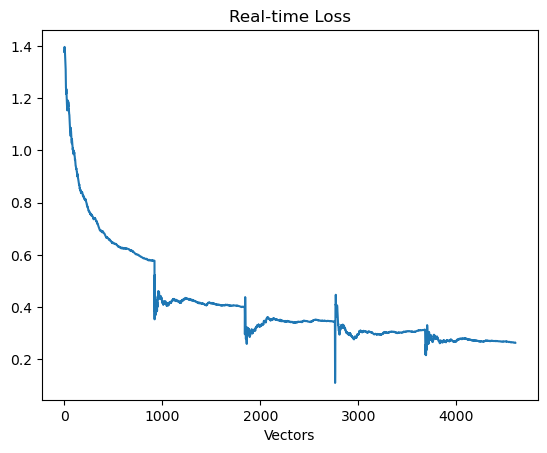

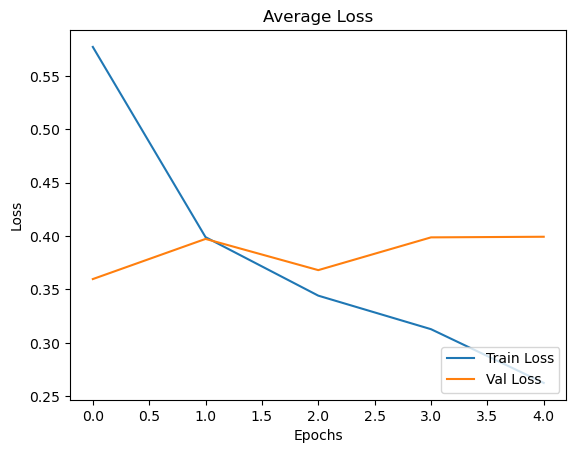

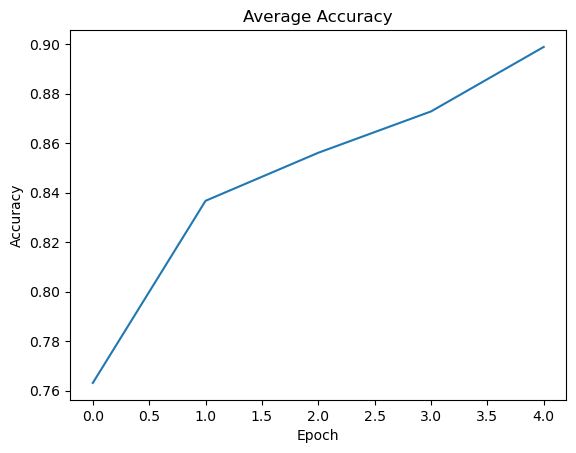

In [23]:
print("ResNet50 Training Analysis")
trainingAnalysis_graph(resnet_info['list_loss_entirety'],
                       resnet_info['acc_list_epoch'],
                       resnet_info['avg_train_loss_epoch'],
                       resnet_info['avg_val_loss_epoch'])
#resnet_info['list_loss_entirety'],resnet_info['acc_list_epoch'],resnet_info['avg_val_loss_epoch']

In [24]:
resnet_f1 = f1_score_analysis(resnet_test_list_pred, resnet_test_list_real)
print(resnet_f1)
print("macro, micro, weighted")

(0.8610733467666647, 0.8695652173913043, 0.8708610356805071)
macro, micro, weighted


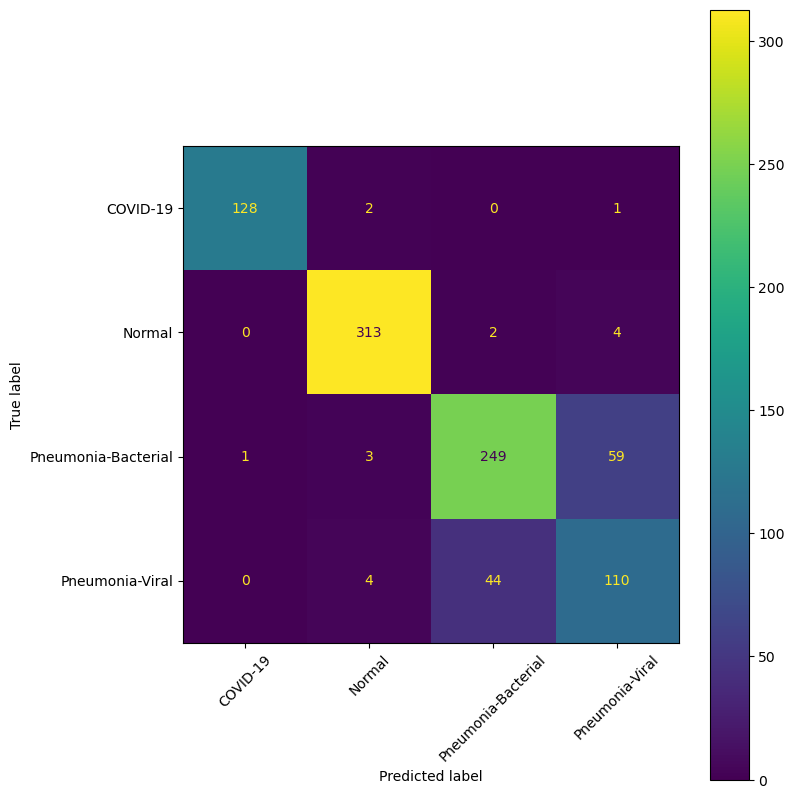

In [25]:
confusion_matrix_creator(resnet_test_list_pred, resnet_test_list_real, ['COVID-19','Normal','Pneumonia-Bacterial','Pneumonia-Viral'])

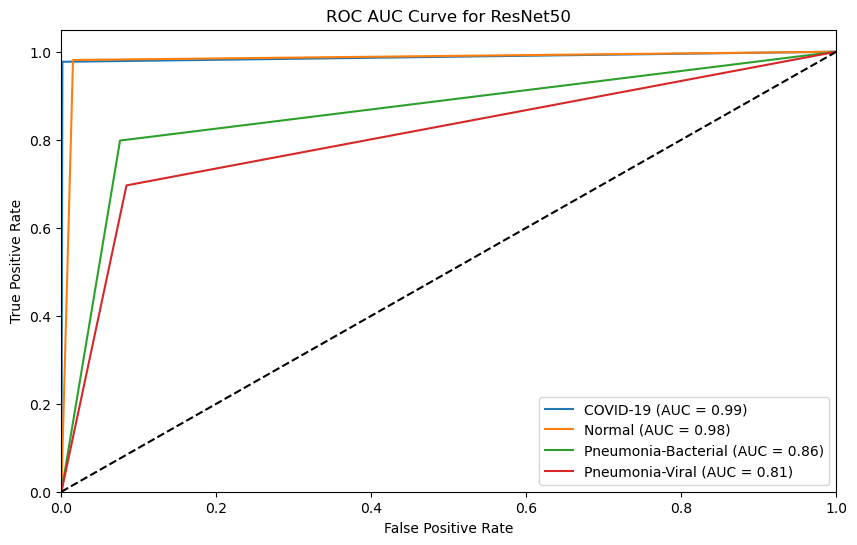

In [26]:
make_roc_auc_curve("ResNet50",resnet_test_list_pred, resnet_test_list_real,
                   ['COVID-19','Normal','Pneumonia-Bacterial','Pneumonia-Viral'])


# VGG16 Training and Analysis

In [27]:
vgg16_, vgg16_info=trainmodel(vgg16_,loss_fn,vgg16_optimizer)

VGG


Validation (7/7): 100%|██████████| 115/115 [00:28<00:00,  3.97it/s, loss=0.3604]


In [28]:
vgg16_simple_acc, vgg16_test_list_pred, vgg16_test_list_real = testmodel(vgg16_, loss_fn)
print(vgg16_simple_acc)

test:: 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]

0.8576086956521739


VGG16 Training Analysis


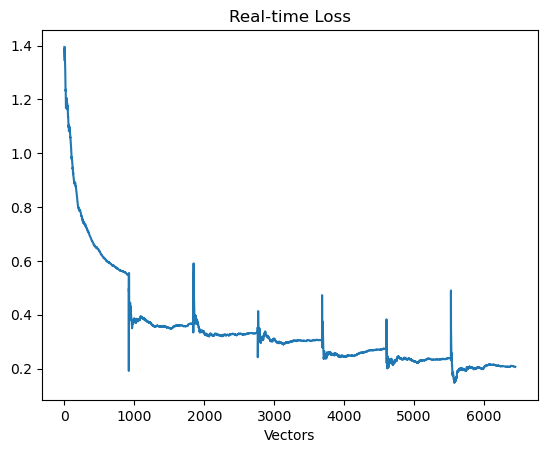

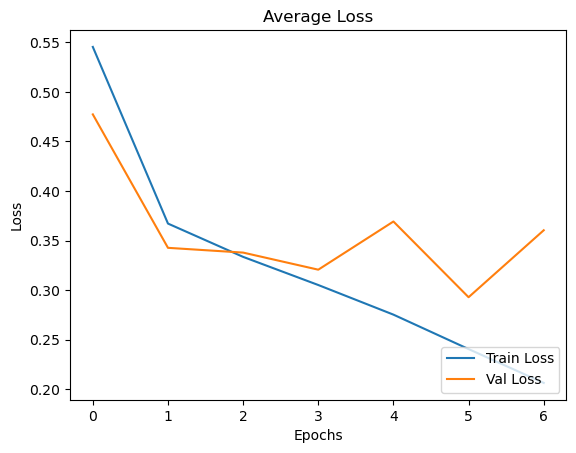

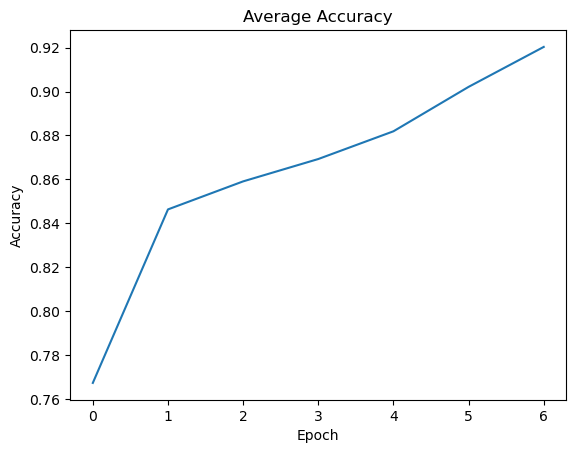

In [29]:
print("VGG16 Training Analysis")
trainingAnalysis_graph(vgg16_info['list_loss_entirety'],
                       vgg16_info['acc_list_epoch'],
                       vgg16_info['avg_train_loss_epoch'],
                       vgg16_info['avg_val_loss_epoch'])

In [30]:
vgg16_f1 = f1_score_analysis(vgg16_test_list_pred, vgg16_test_list_real)
print(vgg16_f1)
print("macro, micro, weighted")

(0.8417908368301059, 0.8576086956521739, 0.8550253215860226)
macro, micro, weighted


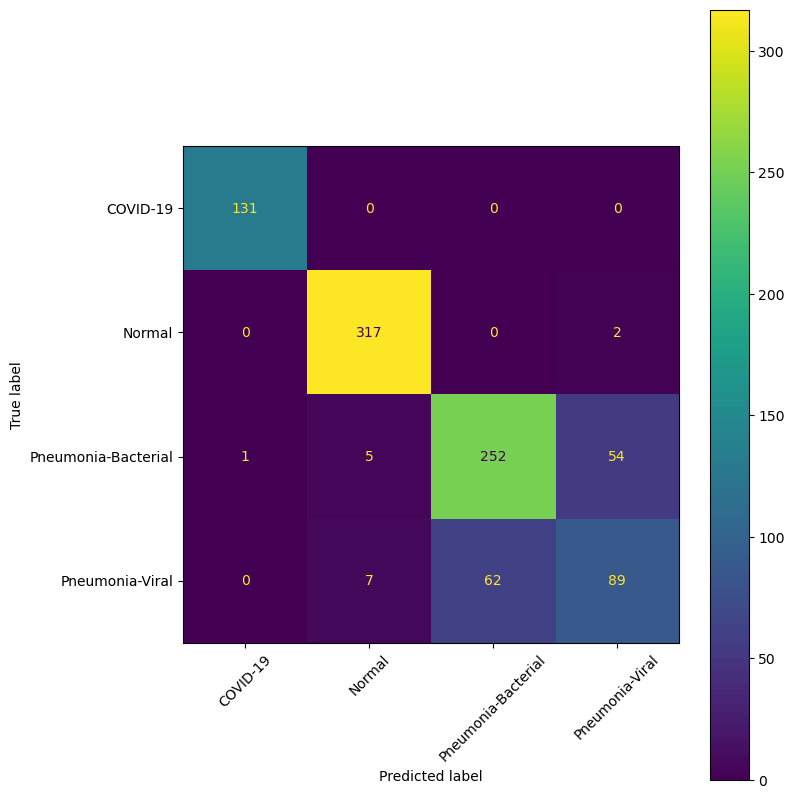

In [31]:
confusion_matrix_creator(vgg16_test_list_pred, vgg16_test_list_real, ['COVID-19','Normal','Pneumonia-Bacterial','Pneumonia-Viral'])

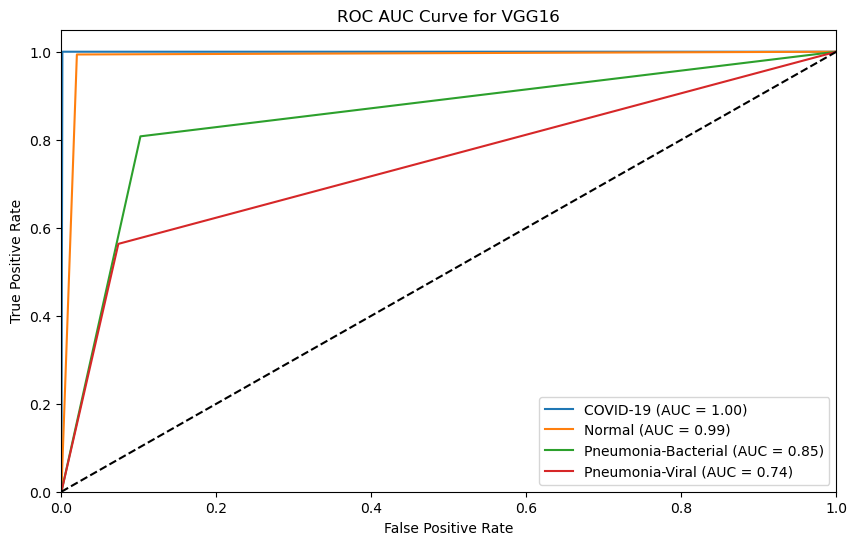

In [32]:
make_roc_auc_curve("VGG16",vgg16_test_list_pred, vgg16_test_list_real,
                   ['COVID-19','Normal','Pneumonia-Bacterial','Pneumonia-Viral'])

```result = {
    'real': [0,1,1,2,0,0,0,....],
    'vgg16': [1,1,0,2,2,...],
    'resnet': [1,2,0,0,0,...],
    'own': [1,2,0,0,0,...],
    
}
def calc_performance(result, real_key = 'real', list_pred_keys: list):
    performance_dict = {
        pred_key: None # this is method name
        for pred_key in list_pred_keys
    }
    for pred_key in list_pred_keys:
        pred = result[pred_key]
        real = result[real_key]
        performance = calculate_metrics(pred, real)
        performance_dict[pred_key] = performance
    return performance_dict

performance_dict = calc_performance(result, 'real', ['method1', 'method2'])
performance_dict = {
    'method1': {
        'acc': 0.9,
        'balance_acc': 0.6,
        'f1': 0.8,
    },
    'method2': {
        'acc': 0.2,
        'f1': 0.3,
    }
}
```